In [1]:
!pip install pmdarima
!pip install pandas openpyxl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 22.9 MB/s eta 0:00:00


In [2]:
# Importação das bibliotecas utilizadas


import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.seasonal import seasonal_decompose

from pmdarima import auto_arima
import matplotlib.pyplot as plt
import numpy as np
import warnings
import xgboost as xgb
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [3]:
import warnings
from pandas.errors import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [4]:
# Leitura dos dados
url = "https://raw.githubusercontent.com/andremanhas/TechChallenge4/main/ipeadata.xlsx"
series = pd.read_excel(url, engine='openpyxl')

# Converter a coluna de data para o formato datetime
series['data'] = pd.to_datetime(series['data'], format='%d/%m/%Y')
series.set_index('data', inplace=True)
series = series.asfreq('D')

# Data de início que você deseja filtrar
data_inicio = '2020-01-01'

# Filtrando os dados a partir da data de início
series = series.loc[data_inicio:]

# Exiba o DataFrame
# Supondo que 'df' é o DataFrame com sua série temporal
print("Série Original")
print(series.head())


series_cleaned = series.dropna()
series = series_cleaned
print("Série Removendo Nulos")
print(series.head())

Série Original
            preco
data             
2020-01-01    NaN
2020-01-02  67.05
2020-01-03  69.08
2020-01-04    NaN
2020-01-05    NaN
Série Removendo Nulos
            preco
data             
2020-01-02  67.05
2020-01-03  69.08
2020-01-06  70.25
2020-01-07  68.74
2020-01-08  67.31


In [5]:
# Verificar valores nulos
print("Valores nulos por coluna:")
print(series.isnull().sum())

# Verificar valores infinitos
print("Valores infinitos por coluna:")
print(np.isinf(series).sum())

Valores nulos por coluna:
preco    0
dtype: int64
Valores infinitos por coluna:
preco    0
dtype: int64


In [6]:
print(f"O dataset possui {series.shape[0]} linhas.")

O dataset possui 1228 linhas.


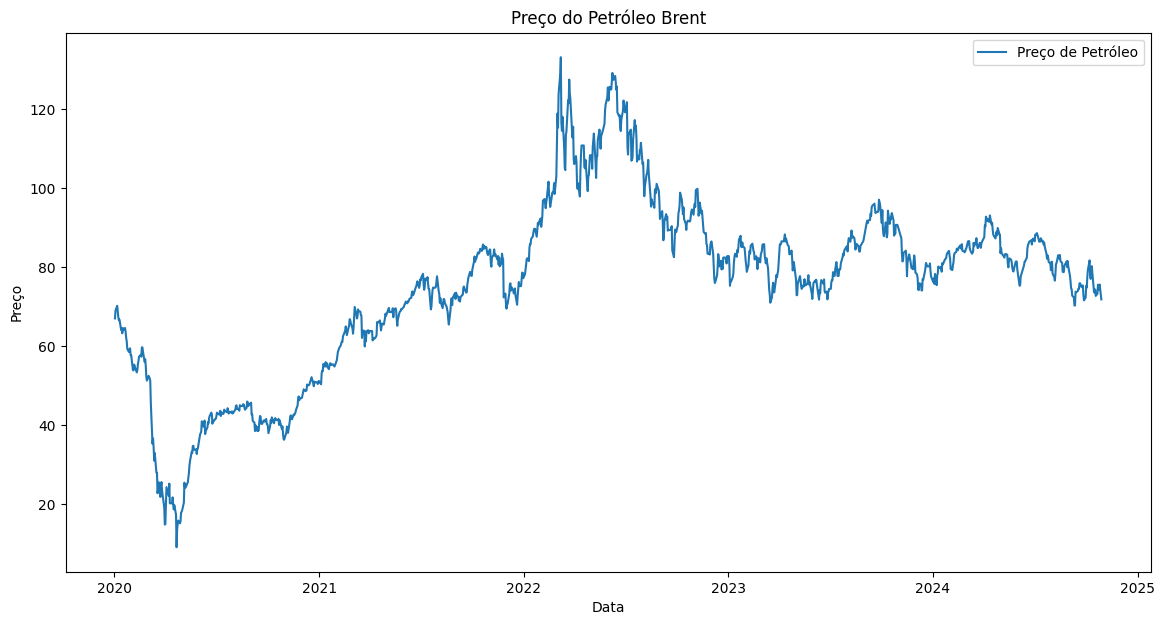

In [7]:
  # Visualização dos dados

plt.figure(figsize=(14, 7))
plt.plot(series["preco"], label="Preço de Petróleo")
plt.title("Preço do Petróleo Brent")
plt.xlabel("Data")
plt.ylabel("Preço")
plt.legend()
plt.show()

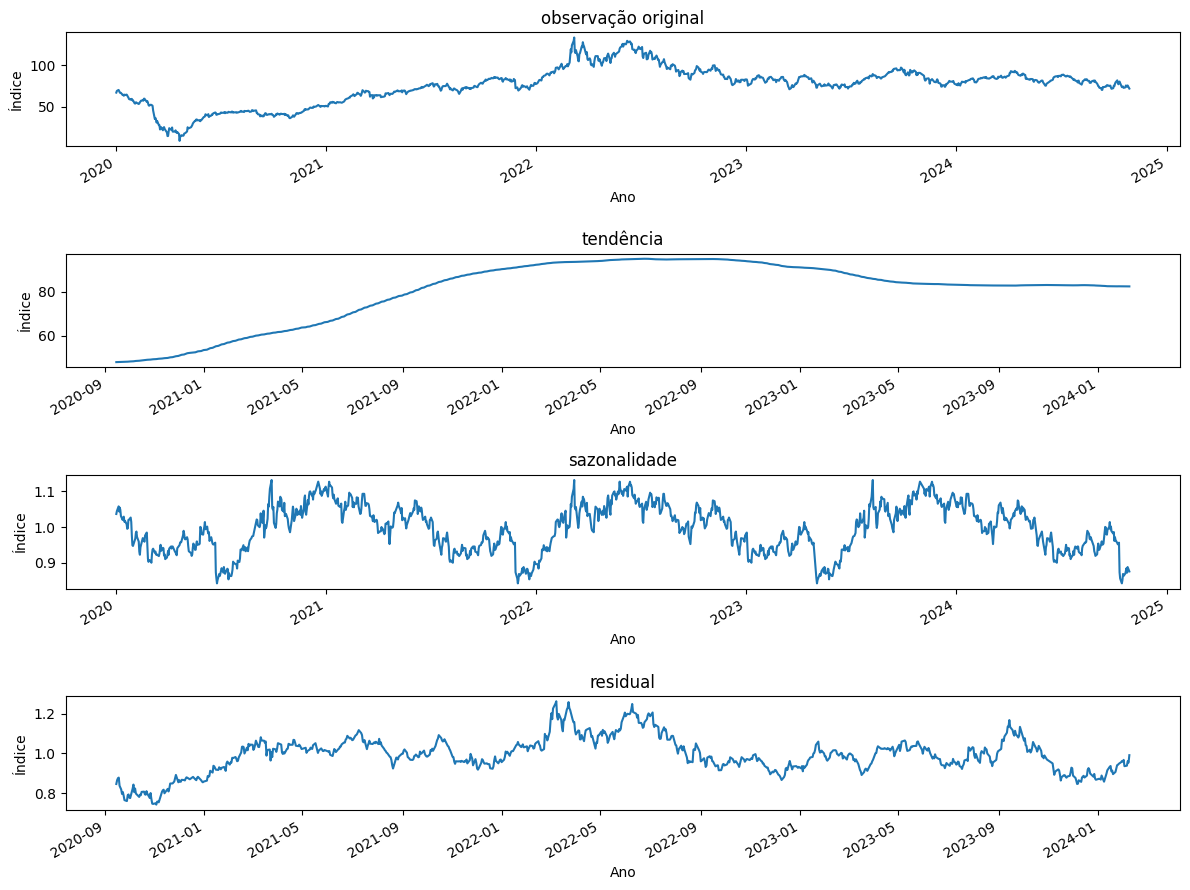

In [8]:
# Analisando os componentes da série temporal

result = seasonal_decompose(series["preco"], model="multiplicative", period=365)

fig, (ax1,ax2,ax3,ax4) = pyplot.subplots(4,1, figsize=(12,9))

result.observed.plot(ax=ax1, title="observação original", ylabel='Índice', xlabel='Ano')
result.trend.plot(ax=ax2, title="tendência", ylabel='Índice', xlabel='Ano')
result.seasonal.plot(ax=ax3, title="sazonalidade", ylabel='Índice', xlabel='Ano')
result.resid.plot(ax=ax4, title="residual", ylabel='Índice', xlabel='Ano')

pyplot.tight_layout()


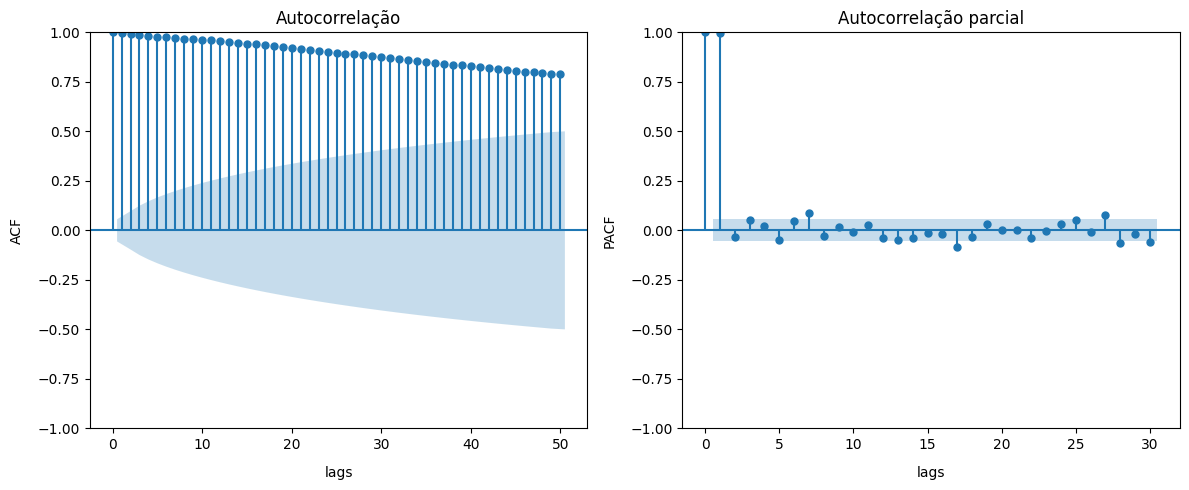

In [9]:
# Gráfico de autocorrelação total e parcial
fig, (ax1,ax2) = pyplot.subplots(1,2, figsize=(12,5))

plot_acf(series, ax=ax1, lags=50)
ax1.set_title('Autocorrelação')
ax1.set_ylabel('ACF', labelpad=10, fontsize=10)
ax1.set_xlabel('lags', labelpad=10, fontsize=10)

plot_pacf(series, ax=ax2, lags=30)
ax2.set_title('Autocorrelação parcial')
ax2.set_ylabel('PACF', labelpad=10, fontsize=10)
ax2.set_xlabel('lags', labelpad=10, fontsize=10)

pyplot.tight_layout()

In [10]:
ad_fuller_test = sm.tsa.adfuller(series["preco"])

print('Dickey-Fuller Aumentado')
print('Teste Estatístico: {:.4f}'.format(ad_fuller_test[0]))
print('Valor-p: {:.4f}'.format(ad_fuller_test[1]))
print('Number of lags used: {:.4f}'.format(ad_fuller_test[2]))
print('Valores Críticos:')
for key, value in ad_fuller_test[4].items():
 print('\t{}: {:.4f}'.format(key, value))

teste = {("Não estacionária" if ad_fuller_test[0] > value else "Estacionária"): value for key, value in ad_fuller_test[4].items()}
print('O teste Dickey-Fuller Aumentado mostra que a série é: {}'.format(list(teste.keys())[0]))

Dickey-Fuller Aumentado
Teste Estatístico: -1.4199
Valor-p: 0.5727
Number of lags used: 6.0000
Valores Críticos:
	1%: -3.4357
	5%: -2.8639
	10%: -2.5680
O teste Dickey-Fuller Aumentado mostra que a série é: Não estacionária


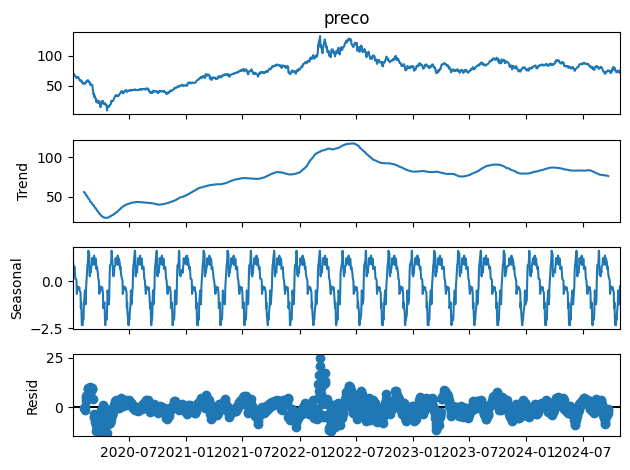

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Frequência estimada automaticamente, ou você pode definir manualmente com "period"
result = seasonal_decompose(series['preco'], model='additive', period=52)
result.plot()
plt.show()


Valores FFT: [ 92409.82      +1.35003120e-12j -11880.65613654+8.95713486e+03j
   4009.09628716+7.42071940e+03j ...  -2730.45117277-3.66789047e+03j
   4009.09628716-7.42071940e+03j -11880.65613654-8.95713486e+03j]
Frequências: [ 0.          0.00081433  0.00162866 ... -0.002443   -0.00162866
 -0.00081433]


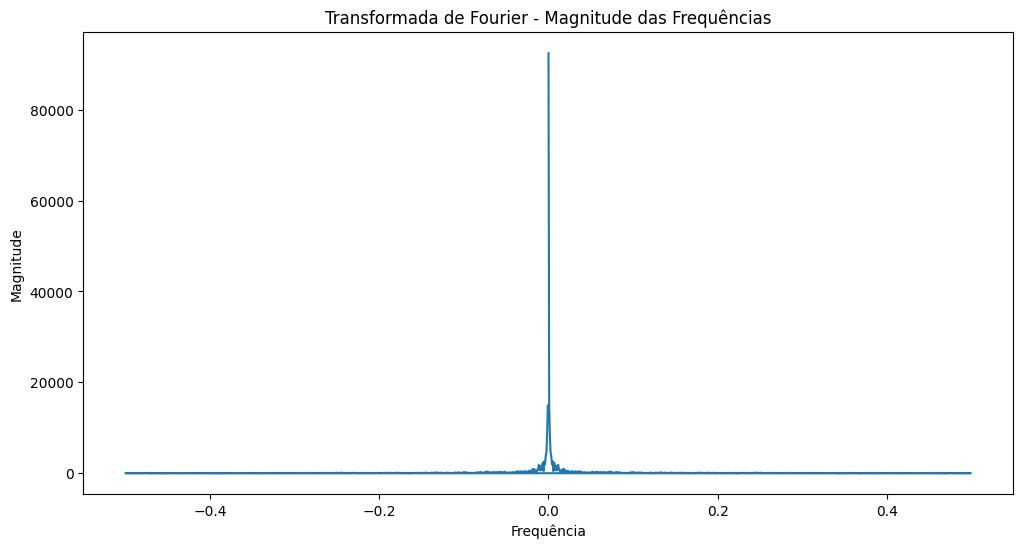

In [12]:
import numpy as np
import pandas as pd
from numpy.fft import fft

# Exemplo de como a série pode ser estruturada
# series = pd.read_csv("seu_arquivo.csv", index_col="data", parse_dates=True)

# Aplicando a transformada de Fourier na coluna 'preco', preenchendo valores nulos
fft_vals = fft(series['preco'].fillna(0))  # Preenchendo valores nulos com 0 (ou use outro método, como interpolação)
frequencies = np.fft.fftfreq(len(fft_vals))

# Visualizando os resultados
print("Valores FFT:", fft_vals)
print("Frequências:", frequencies)

# Plotando os resultados
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plotando a magnitude das frequências
plt.plot(frequencies, np.abs(fft_vals))
plt.title("Transformada de Fourier - Magnitude das Frequências")
plt.xlabel("Frequência")
plt.ylabel("Magnitude")
plt.show()


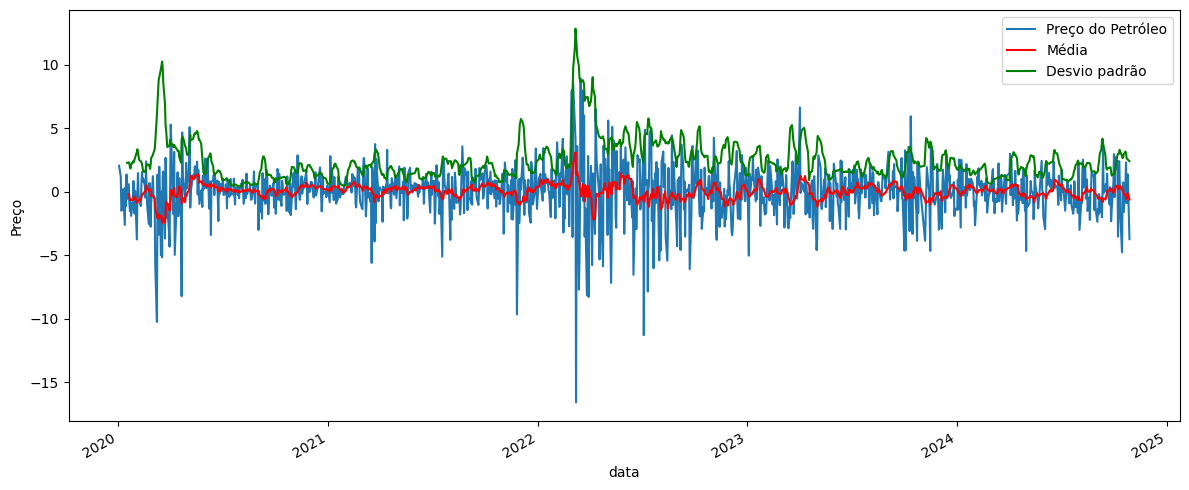

In [13]:
#aplicar diferenciação
df_diff = series.diff(1)
ma_diff = df_diff.rolling(12).mean()
ma_std = series.rolling(12).std()

#plotar a diferenciação
fig, ax = pyplot.subplots(figsize=(12,5))
df_diff.plot(ax=ax)
ma_diff.plot(ax=ax, color='r')
ma_std.plot(ax=ax, color='g')
ax.legend(['Preço do Petróleo', 'Média', 'Desvio padrão'])
ax.set_ylabel('Preço', fontsize=10)
pyplot.tight_layout()

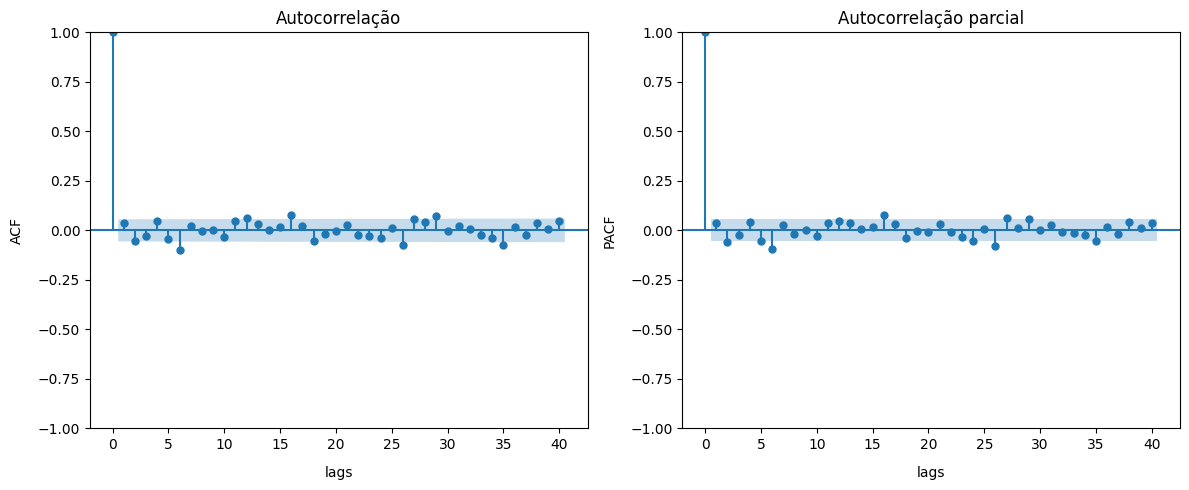

In [14]:
# Gráfico de autocorrelação total e parcial do índice de vendas após a diferenciação da série.

df_diff = series.diff(1)
series_after_diff = df_diff.dropna().values

fig, (ax1,ax2) = pyplot.subplots(1,2, figsize=(12,5))

plot_acf(series_after_diff, ax=ax1, lags=40)
ax1.set_title('Autocorrelação')
ax1.set_ylabel('ACF', labelpad=10, fontsize=10)
ax1.set_xlabel('lags', labelpad=10, fontsize=10)

plot_pacf(series_after_diff, ax=ax2, lags=40)
ax2.set_title('Autocorrelação parcial')
ax2.set_ylabel('PACF', labelpad=10, fontsize=10)
ax2.set_xlabel('lags', labelpad=10, fontsize=10)

pyplot.tight_layout()

In [15]:
df_diff = series.diff(1)
series_after_diff = df_diff.dropna().values

ad_fuller_test = sm.tsa.adfuller(series_after_diff)
print('Dickey-Fuller Aumentado')
print('Teste Estatístico: {:.4f}'.format(ad_fuller_test[0]))
print('Valor-p: {:.4f}'.format(ad_fuller_test[1]))
print('Number of lags used: {:.4f}'.format(ad_fuller_test[2]))
print('Valores Críticos:')
for key, value in ad_fuller_test[4].items():
 print('\t{}: {:.4f}'.format(key, value))

teste = {("Não estacionária" if ad_fuller_test[0] > value else "Estacionária"): value for key, value in ad_fuller_test[4].items()}
print('O teste Dickey-Fuller Aumentado mostra que a série é: {}'.format(list(teste.keys())[0]))

Dickey-Fuller Aumentado
Teste Estatístico: -16.1833
Valor-p: 0.0000
Number of lags used: 5.0000
Valores Críticos:
	1%: -3.4357
	5%: -2.8639
	10%: -2.5680
O teste Dickey-Fuller Aumentado mostra que a série é: Estacionária


In [16]:
train = series['preco'][:int(0.8*len(series))]
test = series['preco'][int(0.8*len(series)):]

test.head()

,preco
data,
2023-11-09,81.74
2023-11-10,83.66
2023-11-13,84.09
2023-11-14,84.20
2023-11-15,82.40


In [17]:
train.head()

,preco
data,
2020-01-02,67.05
2020-01-03,69.08
2020-01-06,70.25
2020-01-07,68.74
2020-01-08,67.31


In [18]:
Arima_stepwise = auto_arima(train, seasonal=False, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)
print(Arima_stepwise.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4285.407, Time=12.44 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4293.771, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4294.414, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4294.226, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4291.817, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4294.562, Time=0.97 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4294.483, Time=0.55 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=4291.430, Time=2.03 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=4291.525, Time=1.68 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4295.170, Time=1.75 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4294.936, Time=2.74 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4295.348, Time=0.84 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=4289.405, Time=2.64 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=4283.456, Time=0.95 sec
 ARIMA(1,1,2)(0,0,0)[0]         

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python

MAE: 1.0969034436824738
MSE: 2.089692655692525
MAPE: 1.3618913682037124%


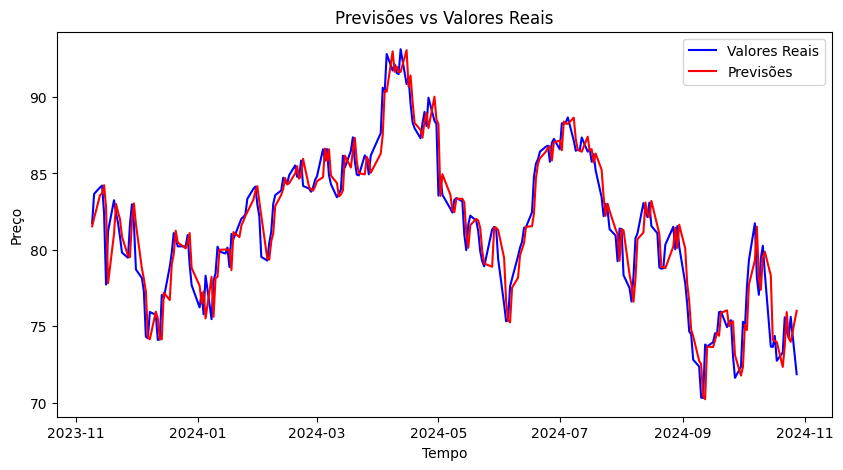

In [19]:
# Ajustar modelo SARIMAX (modificar parâmetros se necessário)
model = SARIMAX(train, order=(2, 1, 2), seasonal_order=(0, 0, 0, 0))
model_fit = model.fit(disp=False)

# Fazer previsões passo a passo (mais robusto para séries não estacionárias)
predictions = []
history = train.tolist()  # Conjunto de dados para atualização iterativa
for t in range(len(test)):
    model = SARIMAX(history, order=(2, 1, 2), seasonal_order=(0, 0, 0, 0))
    model_fit = model.fit(disp=False)
    yhat = model_fit.forecast(steps=1)[0]
    predictions.append(yhat)
    history.append(test.iloc[t])  # Atualiza com o valor real

# Avaliar previsões
mae = mean_absolute_error(test, predictions)
mse = mean_squared_error(test, predictions)
mape = np.mean(np.abs((test - predictions) / test)) * 100

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'MAPE: {mape}%')

# Plotar valores reais vs previsões
plt.figure(figsize=(10, 5))
plt.plot(test.index, test, label='Valores Reais', color='blue')
plt.plot(test.index, predictions, label='Previsões', color='red')
plt.title('Previsões vs Valores Reais')
plt.xlabel('Tempo')
plt.ylabel('Preço')
plt.legend()
plt.show()


In [20]:
# Exibindo as previsões
print(predictions)

[81.53722298617106, 82.08076860599847, 83.58448272112435, 83.69172384994728, 84.23091342795523, 82.77582123199912, 77.81423092527888, 81.04058473478008, 83.0055816937118, 82.46976340616197, 82.02053205001589, 80.86519305727585, 79.62926656303422, 79.5208934841578, 81.86977748246034, 83.03629504064547, 81.68893194414392, 78.79252580528876, 78.10588978757403, 77.27791767992163, 74.30121597934709, 74.1520006274755, 75.95962573128968, 75.51236817359106, 74.16290763530932, 74.15771301737497, 77.20064979278254, 76.7195237622838, 79.03209695083639, 79.70988976191975, 81.25303534367056, 80.49059114700235, 80.09602573367934, 80.46163762819965, 81.09790559036111, 78.81499080855092, 77.65844316670544, 76.50602293635255, 77.27706609762083, 75.51893618142097, 78.23509157907392, 75.62696671460019, 78.14002708236977, 78.23090896449625, 80.00125909653866, 80.02759279111689, 79.97386519869877, 80.036976914361, 78.67411481681944, 81.16022045150106, 80.83052716984919, 81.6015570885958, 81.87983173805326,

In [21]:
# Compare as previsões (preds) com os valores reais do conjunto de teste (test)
# Criando um DataFrame com as previsões e os valores reais lado a lado
comparison_df = pd.DataFrame({'Real': test, 'Previsão': predictions})

# Imprima o DataFrame para comparar os valores
print(comparison_df)

             Real   Previsão
data                        
2023-11-09  81.74  81.537223
2023-11-10  83.66  82.080769
2023-11-13  84.09  83.584483
2023-11-14  84.20  83.691724
2023-11-15  82.40  84.230913
...           ...        ...
2024-10-22  75.59  73.694816
2024-10-23  74.68  75.931476
2024-10-24  74.27  74.236347
2024-10-25  75.62  73.983287
2024-10-28  71.87  76.017151

[246 rows x 2 columns]


In [22]:
# Funções de Avaliação
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mae, mse, mape


def print_metrics(metrics):
    mae, mse, mape = metrics
    print(f"MAE: {mae}")
    print(f"MSE: {mse}")
    print(f"MAPE: {mape}")

In [23]:
# Avaliação ARIMA
metrics_arima = calculate_metrics(test, predictions)
print("ARIMA Metrics:")
print_metrics(metrics_arima)

ARIMA Metrics:
MAE: 1.0969034436824738
MSE: 2.089692655692525
MAPE: 1.3618913682037124


In [24]:
import joblib

# Salvar o modelo ajustado
joblib.dump(model_fit, 'sarimax_model.pkl')

['sarimax_model.pkl']